<a href="https://colab.research.google.com/github/atikhasan007/Computer-Vision/blob/main/Image_Classification_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("hello")

hello


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alsaniipe/flowers-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flowers-dataset' dataset.
Path to dataset files: /kaggle/input/flowers-dataset


# Define data transformatins for data augmentatin and normalization

In [11]:
from typing import dataclass_transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.48,0.456,0.406], [0.229, 0.224, 0.225])

    ])
}

# Define the data Directory

In [18]:
data_dir = '/kaggle/input/flowers-dataset'

In [23]:
import os

# Create data loaders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['val']),

}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1275
     Root location: /kaggle/input/flowers-dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 364
     Root location: /kaggle/input/flowers-dataset/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.48, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [24]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4, shuffle=True,
                                              num_workers=4) for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 1275, 'val': 364}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [25]:
class_names = image_datasets['train'].classes
print(class_names)

['daisy', 'dandelion']


In [29]:
import torchvision.models as models
# Load the pre-trained ResNet 18 model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [30]:
# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
  if "fc" in name: #unfreeze the final classification layer
    param.requires_grad = True
  else:
    param.requires_grad = False

In [31]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [32]:
# move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
mdoel = model.to(device)

In [33]:
# training loop
num_epochs = 10
for epoch in range(num_epochs):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        if phase == 'train':
          loss.backward()
          optimizer.step()
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


print("Training complete!")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.8025 Acc: 0.7176
val Loss: 0.2239 Acc: 0.8956
train Loss: 0.5731 Acc: 0.7937
val Loss: 0.2661 Acc: 0.8846
train Loss: 0.5387 Acc: 0.7875
val Loss: 0.2880 Acc: 0.8846
train Loss: 0.4989 Acc: 0.7914
val Loss: 0.1872 Acc: 0.9341
train Loss: 0.5229 Acc: 0.8063
val Loss: 0.1481 Acc: 0.9368
train Loss: 0.5458 Acc: 0.7922
val Loss: 0.1711 Acc: 0.9396
train Loss: 0.4574 Acc: 0.8220
val Loss: 0.4924 Acc: 0.8132
train Loss: 0.5469 Acc: 0.8102
val Loss: 0.2488 Acc: 0.9093
train Loss: 0.4464 Acc: 0.8259
val Loss: 0.3348 Acc: 0.8846
train Loss: 0.5370 Acc: 0.7851
val Loss: 0.1748 Acc: 0.9176
Training complete!


In [35]:
# save the model
torch.save(model.state_dict(), 'flowers_model.pth')

# classification on unseen image / test data

In [36]:
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np

In [37]:
# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000) # adjust to match the original mdoel
model.load_state_dict(torch.load('flowers_model.pth'))
model.eval()



# Create a new model with the correct final layer

new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)



# Copy the weights and biases form the loaded model to the new_model
new_model.fc.weight.data = model.fc.weight.data[0:2] # copy only the first 2 output
new_model.fc.bias.data = model.fc.bias.data[0:2]



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
image_path = '/kaggle/input/flowers-dataset/test/dandelion/141340262_ca2e576490_jpg.rf.a9e7a7e679798619924bbc5cade9f806.jpg'

In [39]:
image = Image.open(image_path)
# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # fixed last value
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0) # add a batch dimension

In [40]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [41]:
# Perform inference
with torch.no_grad():
    output = new_model(input_batch)

# get the predicted class
_, predicted_class = torch.max(output, 1)
print(predicted_class.item())

#Map the predicted class to the xlass name
class_names = ['daisy', 'dandelion']
predicted_class_name = class_names[predicted_class.item()]
print(f"The predicted class is : {predicted_class_name}")

1
The predicted class is : dandelion


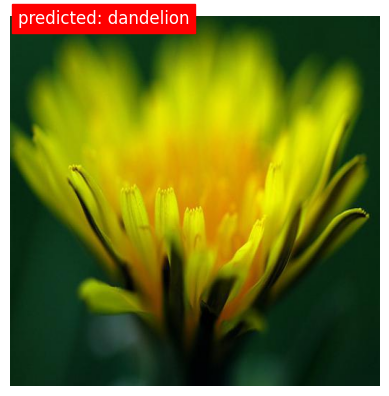

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.text(10,10, f'predicted: {predicted_class_name}', fontsize=12, color='white',
         backgroundcolor='red')
plt.show()